# MNIST dataset Project

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

DESCR key describes the dataset
data key containing an array with one row per instance and one column per feature
target key containing an array with the labels

In [2]:
X,y = mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

Take a look at one digit from the dataset

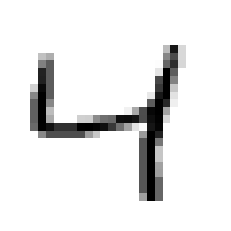

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[2]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [14]:
y[2]

'4'

This looks like a 4,and ineed that's what the label tells us

Cast y to integers

In [3]:
import numpy as np

y = y.astype(np.uint8)

Split the data to test and training data

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary Classifier

Create the "4-detector"

In [17]:
y_train_4 = (y_train == 4)
y_test_4 = (y_test == 4)

Pick Stochastic Gradient Descent Classifier and train it

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_4)

#Use it to detect images of number 4
sgd_clf.predict([some_digit])

array([ True])

## Evaluate the model's performance

Measuring accuracy Using Cross-Validation

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_4,cv=3,scoring="accuracy")

array([0.9671 , 0.97645, 0.9687 ])

Measuring accuracy using Confusion Matrix

In [25]:
from sklearn.model_selection import cross_val_predict

#get a clean prediction for each instance in the training set
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_4,cv=3)

#Get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4,y_train_pred)

array([[52957,  1201],
       [  554,  5288]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 52957 of them were correctly classified as non-4s (they are called true negatives), while the remaining 1201 were wrongly classified as 4s (false positives).
The second row considers the images of 4s (the positive class):524 were wrongly classified as non-4s (false negatives), while the remaining 5288 were correctly classified as 4s (true positives).

Measuring accuracy using precision and recall

In [12]:
from sklearn.metrics import precision_score,recall_score

print(precision_score(y_train_4, y_train_pred))# == 5288/(5288 + 1201)

recall_score(y_train_4, y_train_pred)# == 5288/(5288 + 554)

0.8149175527816305


0.905169462512838

Combine Precision and recall into a single metric(F1 score)

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_4,y_train_pred)

0.8576757764982564

## Precision/Recall Tradeoff

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[3214.66574913]


array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., True ). Let’s raise the threshold:

In [15]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 4, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.

Decide which treshold to use

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3,
                             method="decision_function")

Now with these scores we can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

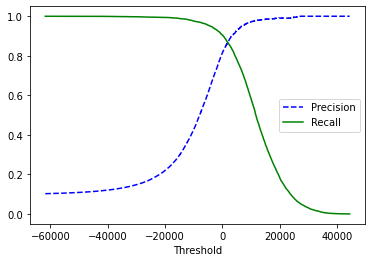

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

#Plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

So let’s suppose we decide to aim for 90% precision.We look up the plot and find that we need to use a threshold of about 8,000. To be more precise we can search for the lowest threshold that gives us at least 90% precision (np.argmax() will give us the first index of the maximum value, which in this case means the first True value):

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

#To make predictions (on the training set for now), instead of calling the classifier’s
#predict() method, you can just run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Check these predictions’ precision and recall:

In [19]:
print(precision_score(y_train_4, y_train_pred_90))
print(recall_score(y_train_4, y_train_pred_90))

0.9001287474710318
0.8377268058883944


Plot the ROC(receiver operating characteristic) curve

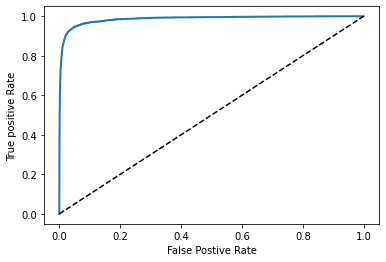

In [20]:
#To plot the ROC curve,we first need to compute the TPR and FPR for 
#various threshold values, using the roc_curve() function:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False Postive Rate")
    plt.ylabel("True positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)

0.9859276923382874

Train a RandomForestClassifier and compare its ROC curve and ROC AUC
score to the SGDClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_4,cv=3,
method="predict_proba")

To plot a ROC curve,we need scores,not probabilities. A simple solution is to use the positive class’s probability as the score:

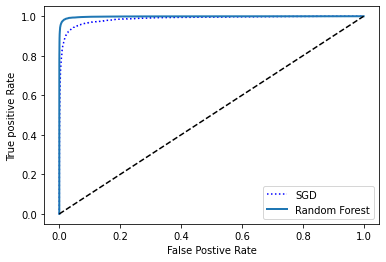

In [23]:
y_scores_forest = y_probas_forest[:, 1]
# score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4,y_scores_forest)

#Plot the ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

We can see that the RandomForestClassifier’s ROC curve looks a bit
better than the SGDClassifier’s:it comes much closer to the top-left corner.As a result, its ROC AUC score is also significantly better:

In [24]:
roc_auc_score(y_train_4, y_scores_forest)

0.9982278527638186

## Multiclass Classification

One versus all strategy

In [20]:
sgd_clf.fit(X_train,y_train)  #y_train,not y_train4
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

Under the hood,Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.This happerns because Linear Classifiers like SGD are strictly binary classifiers.

To see that this is indeed the case,we call the decision_function() method.Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [21]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-34143.40703505, -21942.13780869,  -4018.29275037,
         -2239.19313075,     43.09419826, -15058.88052383,
        -33653.31059893,  -8277.80610963,  -7460.52016321,
        -14180.15338984]])

The highest score is indeed the one corresponding to class 4:

In [22]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
sgd_clf.classes_[4]

4
[0 1 2 3 4 5 6 7 8 9]


4

Use OneVsOneClassifier

In [28]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=uint8)

Train a RandomForestClassifier

In [27]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([4], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes.Call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class

In [30]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.02, 0.  , 0.95, 0.  , 0.  , 0.01, 0.01, 0.01]])

We can see that the classifier is fairly confident about its prediction:the model estimates a 95% probability that the image represents a 4,2% that is a 2 and 1% that is 7,8 and 9.

Evaluate the classifiers

In [31]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets overs 85% on all test folds.If we used a random classifier,we would get 10% accuracy, so this is not such a bad score,but we can still do better.Try scaling the inputs

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

Look at the confusion matrix

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Visualize the results

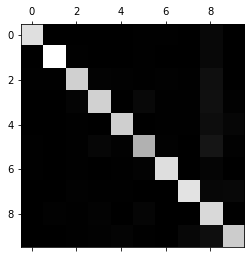

In [30]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal,which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact,we can verify that both are the case.

Let’s focus the plot on the errors. First,we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute number of errors(which would make abundant classes look unfairly bad):

In [31]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

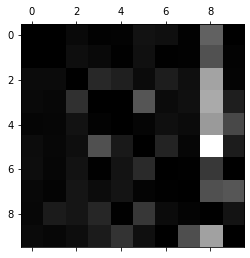

In [32]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kinds of errors the classifier makes.Rows
represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s.We can also see that 3s and 5s often get confused (in both directions).

Analyzing the confusion matrix can often give us insights on ways to improve our classifier. Looking at this plot, it seems that our efforts should be spent on reducing the false 8s.We could try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s.

## Multilabel Classification

Classify if a digit is large or if is odd or not

In [5]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Make a prediction

In [34]:
knn_clf.predict([some_digit])

array([[False, False]])

It gets it right.The digit 4 is not large and not odd

Evaluate the classifier

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605
